# Deep Learining Project 2
###    Wojciech Wieczorek 145465
###    Jerzy Łukaszewicz 145458

For each class, there is one pattern occurring in the data. Solving just a classification task be scored no higher than 70%. 

Please provide either pdf with the report or add some notes in the notebook. Demonstrate some examples of how your approach works.

A short reminder of your task:
 - Correct classification of provided time series
 - Explanation of the prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [2]:
from tensorflow.keras.layers import LSTM, GRU, Dense, Input, RepeatVector, TimeDistributed, Flatten, Softmax
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import Sequence, plot_model
import tensorflow.keras.backend as K
import tensorflow as tf

In [3]:
np.random.seed(42)

In [4]:
n = 50000

In [5]:
def createRow(n, classes):
    base = np.sin(np.linspace((np.random.rand(3)),(np.random.rand(3) + np.array([10,15,7])),n))
    if classes[0] > 0:
        base[np.random.randint(0,n), 0] += 2
    if classes[1] > 0:
        base[np.random.randint(0,n), 1] -= 2
    if classes[2] > 0:
        x = np.random.randint(0,n-5)
        base[x:x+4,2] = 0
    if classes[3] > 0:
        x = np.random.randint(0,n-10)
        base[x:x+8,1] += 1.5
    if classes[4] > 0:
        x = np.random.randint(0,n-7)
        base[x:x+6,0] += 1.5
        base[x:x+6,2] -= 1.5
    base += np.random.rand(*base.shape)*.2
    return base

In [6]:
xl, yl = [], []
for _ in range(n):
    cl = np.random.rand(5)<.25
    xl.append(createRow(np.random.randint(40,60), cl))
    yl.append(cl)  

[False False False False  True]


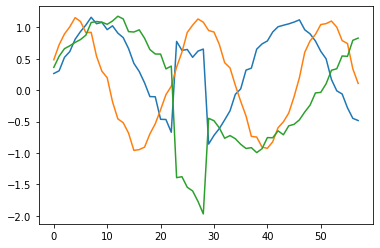

[False False False  True  True]


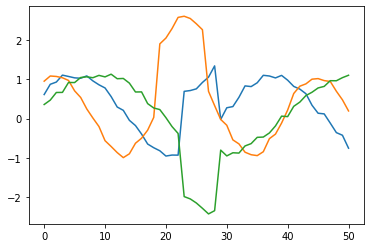

[False False False False False]


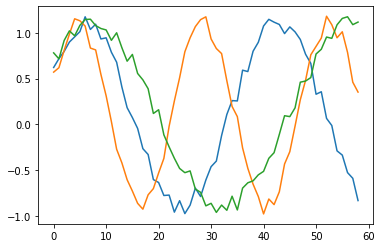

In [7]:
for i in range(3):
    plt.plot(xl[i])
    print(yl[i])
    plt.show()

In [8]:
padded_xl = tf.keras.preprocessing.sequence.pad_sequences(
    xl, padding="post",dtype='float32'
)

In [9]:
padded_xl.shape

(50000, 59, 3)

In [10]:
padded_xl = np.array(padded_xl)
new_yl = np.array(yl).astype(int)

#### Split sizes: 
* 80% - train
* 10% - validation
* 10% - test

In [11]:
X_train, X_test, y_train, y_test = train_test_split(padded_xl, new_yl, test_size=0.2, random_state=42)

In [12]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [15]:
model = Sequential()
model.add(Input(shape=(None, 3)))
model.add(LSTM(64,return_sequences=True))
model.add(LSTM(32,return_sequences=True))
model.add(LSTM(32,return_sequences=True))
model.add(LSTM(32,return_sequences=False))
model.add(Dense(5,activation='sigmoid'))
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, None, 64)          17408     
                                                                 
 lstm_5 (LSTM)               (None, None, 32)          12416     
                                                                 
 lstm_6 (LSTM)               (None, None, 32)          8320      
                                                                 
 lstm_7 (LSTM)               (None, 32)                8320      
                                                                 
 dense_1 (Dense)             (None, 5)                 165       
                                                                 
Total params: 46,629
Trainable params: 46,629
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
model.fit(X_train,y_train, epochs=25, validation_data = (X_val, y_val), batch_size=64,verbose=1, callbacks=[callback])

Epoch 1/25
277/625 [============>.................] - ETA: 14s - loss: 0.5363 - recall_1: 0.0694 - precision_1: 0.9225

In [ ]:
model.evaluate(X_test,y_test)

In [ ]:
class PointDataGen(Sequence):
    
    def __init__(self, df, sequenceLen=50, batchSize=1, shuffle=True):
        
        self.sequenceLen = sequenceLen
        self.batchSize = batchSize
        self.shuffle = shuffle
        self.df = df
        
    def on_epoch_end(self):
        np.random.shuffle(self.df)
    
    def __get_data(self, batches):
        output = np.zeros((len(batches), self.sequenceLen+1))
        for i,x in enumerate(batches):
            output[i] = np.sin(np.linspace(x, x+4, self.sequenceLen+1))
        if self.shuffle:
            output += np.random.randn(*output.shape)/100
        
        return output[:,:-1], output[:, -1]
    
    def __getitem__(self, index):
        
        batches = self.df[index * self.batchSize:(index + 1) * self.batchSize]
        X, y = self.__get_data(batches)        
        return X.reshape(len(batches), self.sequenceLen, 1), y
    
    def __len__(self):
        return len(self.df) // self.batchSize